# Reimplementation of the best performing algorithm from Killourhy and Maxion's research paper for static authentication 

Comparing Anomaly-Detection Algorithms for Keystroke Dynamics

In [1]:
import pandas as pd
import numpy as np
import sklearn as sc
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import metrics
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from sklearn.model_selection import train_test_split
from sklearn.neighbors import DistanceMetric
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pyplot import figure
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense, Input

ModuleNotFoundError: No module named 'tensorflow'

# Load Data

In [2]:
data = pd.read_csv("datasets/killourhy_maxion_password.csv")

In [3]:
data = data[data.columns.drop(list(data.filter(regex='H')))]
data = data[data.columns.drop(list(data.filter(regex='UD')))]

# data = data[data.columns.drop(list(data.filter(regex='DD')))]

data.head()

,subject,sessionIndex,rep,DD.period.t,DD.t.i,DD.i.e,DD.e.five,DD.five.Shift.r,DD.Shift.r.o,DD.o.a,DD.a.n,DD.n.l,DD.l.Return
0,s002,1,1,0.3979,0.1674,0.2212,1.1885,1.6055,0.7590,0.2136,0.1484,0.3515,0.3509
1,s002,1,2,0.3451,0.1283,0.1357,1.1970,0.7822,0.7877,0.1684,0.2558,0.2642,0.2756
2,s002,1,3,0.2072,0.1291,0.1542,1.0408,0.6203,0.7195,0.2931,0.2332,0.2705,0.2847
3,s002,1,4,0.2515,0.2495,0.2038,1.0556,1.2564,0.7550,0.1530,0.1629,0.2341,0.3232
4,s002,1,5,0.2317,0.1676,0.1589,0.8629,0.8955,0.7632,0.1975,0.1582,0.2517,0.2517


In [4]:
data = data[data.columns.drop(['sessionIndex', 'rep'])]
data["subject"] = data["subject"].apply(lambda x: int(x[1:]))
subjects = data.subject.unique().tolist()
data.head()

,subject,DD.period.t,DD.t.i,DD.i.e,DD.e.five,DD.five.Shift.r,DD.Shift.r.o,DD.o.a,DD.a.n,DD.n.l,DD.l.Return
0,2,0.3979,0.1674,0.2212,1.1885,1.6055,0.7590,0.2136,0.1484,0.3515,0.3509
1,2,0.3451,0.1283,0.1357,1.1970,0.7822,0.7877,0.1684,0.2558,0.2642,0.2756
2,2,0.2072,0.1291,0.1542,1.0408,0.6203,0.7195,0.2931,0.2332,0.2705,0.2847
3,2,0.2515,0.2495,0.2038,1.0556,1.2564,0.7550,0.1530,0.1629,0.2341,0.3232
4,2,0.2317,0.1676,0.1589,0.8629,0.8955,0.7632,0.1975,0.1582,0.2517,0.2517


In [5]:
# features
X = data[data.columns.drop(['subject'])]

In [6]:
s_id = 19

# create dataset of this user
s = data[data["subject"] == s_id]
X = s[s.columns.drop(['subject'])]

X

,DD.period.t,DD.t.i,DD.i.e,DD.e.five,DD.five.Shift.r,DD.Shift.r.o,DD.o.a,DD.a.n,DD.n.l,DD.l.Return
5600,0.4802,0.5065,0.3181,0.5465,1.6011,0.4305,0.6396,0.3835,0.4101,0.8998
5601,0.4420,0.4014,0.3175,0.9197,0.6844,0.3980,0.1986,0.5379,0.3747,0.8030
5602,0.5353,0.4128,0.4695,0.6544,0.9767,0.4450,0.3862,0.3675,0.3560,0.6056
5603,0.4955,0.4133,0.6004,0.7452,1.0027,0.3869,0.3653,0.2957,0.4474,0.9990
5604,0.3589,0.3336,0.2821,0.4496,0.9548,0.3791,0.1962,0.2089,0.3616,0.7381
...,...,...,...,...,...,...,...,...,...,...
5995,0.2340,0.2349,0.0771,0.2347,0.3410,0.2722,0.0611,0.1761,0.2270,0.4274
5996,0.2356,0.2983,0.0655,0.2512,0.4897,0.3155,0.0753,0.1833,0.2442,0.4659
5997,0.2551,0.2165,0.0790,0.2438,0.4572,0.4748,0.0799,0.1975,0.2288,0.3809
5998,0.2169,0.4574,0.0890,0.2473,1.0206,0.3273,0.0920,0.1832,0.2045,0.4245


In [7]:
# divide between train and test
X_train = X.head(200)
X_test = X.tail(200)

# NN AutoEncoder

In [8]:
dim= X_train.shape[1]

input = Input(shape=(dim,))
hidden = Dense(dim, activation="sigmoid",
    kernel_initializer='random_normal',
    bias_initializer='zeros')(input)
output = Dense(dim, activation="linear",
    kernel_initializer='random_normal',
    bias_initializer='zeros')(hidden)

autoencoder = Model(inputs=input, outputs=output)

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 220
Trainable params: 220
Non-trainable params: 0
_________________________________________________________________


In [9]:
opt = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.0003)
autoencoder.compile(optimizer=opt, loss='mse')
autoencoder.fit(X_train, X_train, epochs=500, verbose=0)

In [10]:
predictions = autoencoder.predict(X_test)
print(predictions)

[[0.14811783 0.03634981 0.05095791 ... 0.12085219 0.09309587 0.15506092]
 [0.1522454  0.03313317 0.05227542 ... 0.11953025 0.09533991 0.15931077]
 [0.15104969 0.03283983 0.05156869 ... 0.12113212 0.09453289 0.15900342]
 ...
 [0.15207121 0.03303975 0.05244446 ... 0.11968694 0.09517601 0.15947013]
 [0.15182284 0.03355514 0.0529317  ... 0.11808484 0.09608057 0.1585944 ]
 [0.15221483 0.03270576 0.05189046 ... 0.1203957  0.09518449 0.15959795]]


In [11]:
weights = autoencoder.get_weights()
print(weights)

[array([[-0.05963796, -0.0510705 , -0.01776614,  0.01988005,  0.0677663 ,
        -0.01868385,  0.01504957,  0.01619641, -0.00223189,  0.0251342 ],
       [-0.13281362, -0.07160412, -0.05942185,  0.0241575 ,  0.00640971,
         0.03316759,  0.04365025, -0.03080972,  0.10990369, -0.04271519],
       [-0.12151188,  0.00623415,  0.04993914,  0.04314667, -0.03217715,
        -0.08348028, -0.05878751,  0.0665221 , -0.08115247, -0.05541814],
       [ 0.0370336 , -0.03046222, -0.01607679,  0.00257707,  0.01523727,
        -0.07822356, -0.00961096,  0.01302236, -0.02037694, -0.04175258],
       [ 0.03129938, -0.04580081, -0.03659629,  0.07762717, -0.08224657,
         0.02757943,  0.03595991, -0.01559734, -0.02189416,  0.04708374],
       [-0.01150221, -0.06772973,  0.03652573,  0.04054084, -0.01247802,
         0.07500248,  0.04051434,  0.04719415,  0.06134764, -0.09789661],
       [ 0.01069033,  0.03212527, -0.03962505, -0.04219509,  0.00186454,
         0.10049343,  0.08453096,  0.0768075

In [12]:
from scipy.spatial import distance
anomaly_user_score = []

for i in range(0, X_test.shape[0]):
    # distance = math.sqrt(sum([(a - b) ** 2 for a, b in zip(X_train.iloc[i], X_test.iloc[i])]))
    # dist = np.linalg.norm(X_train.iloc[i]-X_test.iloc[i])
    dist = distance.euclidean(X_test.iloc[i], predictions[i])

    anomaly_user_score.append(dist)

In [13]:
print(len(anomaly_user_score))

200


In [14]:
print(anomaly_user_score)

[1.7737735616937604, 0.7025427658987259, 0.8385257903044053, 0.8698856112642824, 1.067924988878341, 0.8090146844588936, 1.4159027780109308, 0.5600582986487247, 0.6801223577393385, 0.8159027222683285, 0.614869364109593, 0.6236433529354685, 0.6681964595510768, 1.1372766465552664, 1.1391154098550158, 0.5920875808883114, 1.1938940594684455, 0.5876941840162323, 0.688728908975877, 0.6365705574200805, 0.6767887240609858, 0.718086572357541, 0.6612625564219704, 0.5876788367883901, 0.662952820769802, 0.6253919115494464, 0.6194382403332822, 0.5829967545846411, 0.6614211934803604, 0.6280215270354692, 0.6026993487964034, 0.6424398374903268, 0.5972409632885733, 0.563035015437396, 0.6210368403390353, 0.5967127467805298, 0.5742449891872897, 0.5927838999801927, 0.6182624001803227, 0.6072425045604808, 0.6177859307326946, 0.5910013037961053, 0.6395391819501655, 0.6711360706313474, 0.6735518054445516, 0.6743697466819392, 0.7167857167188839, 0.6247453213174119, 0.6539037793309466, 0.6547433993380956, 1.111

Multiple impostors

In [15]:
# test phase of detector of impostor
i = 0

subjects_to_iterate = subjects
subjects_to_iterate.remove(s_id)
print(subjects_to_iterate)

[2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57]


In [16]:
anomaly_impostor_score = []
for x in subjects_to_iterate:

    # get impostor dataframe
    si = data[data["subject"] == x]
    Xi = si[si.columns.drop(['subject'])]
    Xi_test = Xi.head(5)

    # test the first five

    ## Neural Network
    tmp_impostor_score = []
    predictions = autoencoder.predict(Xi_test)
    for i in range(0, Xi_test.shape[0]):
        dist = distance.euclidean(Xi_test.iloc[i], predictions[i])
        tmp_impostor_score.append(dist)

    # record the results
    # if it is the first time, save it as base
    if i == 0:
        anomaly_impostor_score = tmp_impostor_score
    # append it to existing if not the first one
    else:
        anomaly_impostor_score = np.append(anomaly_impostor_score, tmp_impostor_score)

    i = i +1

In [17]:
print(anomaly_impostor_score)

[2.05897261 1.53956125 1.33943957 1.709729   1.36508628 0.99735495
 1.00919469 0.8616161  1.19322972 1.28469029 1.00923298 1.63177921
 1.26544576 1.21711833 0.99959742 2.12545963 1.78365774 1.91347342
 1.30342492 1.18747165 1.11709676 0.9626195  1.06516194 1.14360221
 0.59242981 0.91800795 0.77196665 0.62930906 0.67233827 0.64695536
 0.75777545 0.87088855 0.74774847 0.76294496 0.34989432 0.88141552
 0.67456072 0.57289267 0.78194524 1.43536847 1.27933096 1.31993546
 1.0591144  1.63335619 1.45538066 0.98104009 0.41912943 0.87833679
 0.88707916 0.61438675 1.08231473 1.01687732 0.58535128 0.55225246
 1.0251768  1.7394972  1.82517178 1.59185746 1.88983916 1.75412568
 0.5556398  1.43855343 0.59884678 0.57287571 0.63006391 1.51093712
 1.27976646 1.29484404 1.0792662  0.66897928 2.42352786 0.89932574
 1.01488256 0.68753109 0.69459716 1.62549612 1.18502375 0.72839772
 0.56553402 0.63910899 3.00974434 2.69430817 2.70472357 2.75312861
 2.6172465  1.24384683 1.57318862 1.80921747 1.2069556  0.8525

## Threshold for acceptance

Assuming Gaussian distribution

In [18]:
user_mean = np.mean(anomaly_user_score)
user_std = np.std(anomaly_user_score)
user_min = np.min(anomaly_user_score)
user_max = np.max(anomaly_user_score)

impostor_mean = np.mean(anomaly_impostor_score)
impostor_std = np.std(anomaly_impostor_score)
impostor_min = np.min(anomaly_impostor_score)
impostor_max = np.max(anomaly_impostor_score)

if user_max >= impostor_max:
    plot_max = user_max
else:
    plot_max = impostor_max

if user_min <= impostor_min:
    plot_min = user_min
else:
    plot_min = impostor_min

print(plot_min)
print(plot_max)

0.34989431783044284
6.0103777551450905


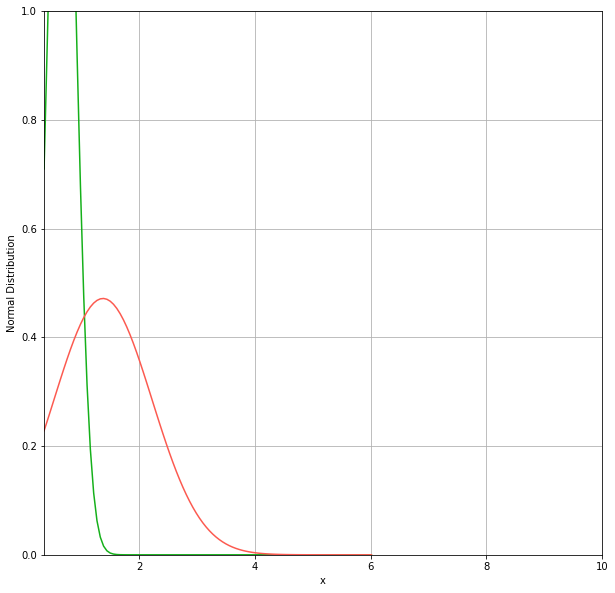

In [26]:
# Plotting
plt.figure(figsize=(10,10))

x = np.linspace(plot_min, plot_max, 100)

y_user = scipy.stats.norm.pdf(x,user_mean,user_std)
y_impostor = scipy.stats.norm.pdf(x,impostor_mean,impostor_std)

plt.plot(x,y_user, color='xkcd:green')
plt.plot(x,y_impostor, color='xkcd:coral')


plt.grid()

plt.xlim(plot_min,10)
plt.ylim(0,1)

plt.xlabel('x')
plt.ylabel('Normal Distribution')

# plt.savefig("normal_distribution_user_impostor.png")
plt.show()

In [20]:
fpr = [1]
tpr = [1]
threshold = [0]

# For each possible threshold
for t in np.arange(0, int(plot_max), 0.01):
    
    y_score = []
    y_true = []

    # False alarm rate so False Positive Rate
    # Every user mistaken as impostor
    for e in anomaly_user_score:

        # true label
        y_true.append(0)

        # print("score : " + str(e))
        # print("threshold : " + str(t))
        # score label
        if e > t:
            y_score.append(1)
        else:
            y_score.append(0)

        # print(y_score)

    # Hit Rate so True Positive Rate
    # Every impostor as user
    for e in anomaly_impostor_score:

        # true label
        y_true.append(1)

        # score label
        if e > t:
            y_score.append(1)
        else:
            y_score.append(0)

    tn, fp, fn, tp = confusion_matrix(y_true, y_score).ravel()
    # print("True Negative : " + str(tn))
    # print("False Positive : " + str(fp))
    # print("False Negative : " + str(fn))
    # print("True Positive : " + str(tp))

    p = tp + fn
    n = fp + tn

    temp_fpr = fp / n
    temp_tpr = tp / p
    # print("False Positive Rate : " + str(fpr))
    # print("True Positive Rate : " + str(tpr))

    fpr.append(temp_fpr)
    tpr.append(temp_tpr)
    threshold.append(t)


fpr.append(0)
tpr.append(0)
threshold.append(int(plot_max))

In [21]:
print(len(fpr))
print(len(tpr))
print(len(threshold))

602
602
602


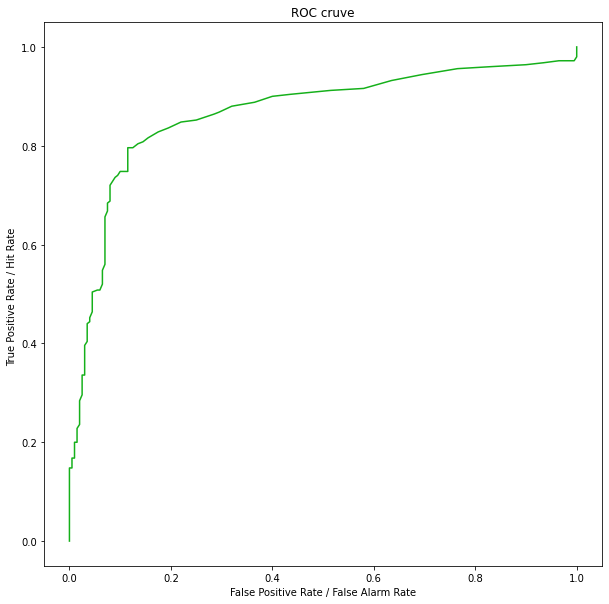

In [22]:
plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='xkcd:green',)
plt.xlabel('False Positive Rate / False Alarm Rate')
plt.ylabel('True Positive Rate / Hit Rate ')
plt.title('ROC cruve')
plt.show()

In [23]:
# Calculate EER

# TODO: is this correct manner ?
eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
thresh = interp1d(fpr, threshold)(eer)

print(eer)
# print(thresh)

0.173125


In [24]:
# Calculate the zero-miss false-alarm rate

# This is when the Hit Rate is equal 1 / Miss Rate is 0

for index, val in enumerate(tpr):
    # print(val)
    if val == 1:
        zero_miss_false_alarm = fpr[index]

print(zero_miss_false_alarm)

1.0
